***
<font size="6"><center><b> Caspsule Networks (CIFAR100_JUST FINE CLASS_BASED ON PAPER) </b></center></font>
***

# Import Necessary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

DONE loading MixUp Data generator
DONE loading MixUp Data generator


In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\GitHub Repo\HDeep_CapsNet\code\training\Stanford_Cars
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


## For GPU growth (not required if GPU does not give any error)

In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "3" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  3
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Import Dataset : Stanford Cars

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 8,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }

In [5]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.Stanford_Cars(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup',
                                                                                  data_normalizing = None)

In [6]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

# CapsNet Layers

In [7]:
def squash(s, axis=-1, name="squash"):
    """
    non-linear squashing function to manupulate the length of the capsule vectors
    """
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                         keepdims=True)
        safe_norm = tf.sqrt(squared_norm + keras.backend.epsilon())
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [8]:
def safe_norm(s, axis=-1, keepdims=False, name="safe_norm"):
    """
    Safe computation of vector 2-norm
    """
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                 keepdims=keepdims)
        return tf.sqrt(squared_norm + keras.backend.epsilon())    

In [9]:
class SecondaryCapsule(keras.layers.Layer):
    """
    The digit capsule layer. 
    input shape = [None, input_num_capsule, input_dim_capsule] 
    output shape = [None, num_capsule, dim_capsule]
    :param n_caps: number of capsules in this layer
    :param n_dims: dimension of the output vectors of the capsules in this layer
    """
    def __init__(self, n_caps, n_dims, routings=2, **kwargs):
        super().__init__(**kwargs)
        self.n_caps = n_caps
        self.n_dims = n_dims
        self.routings = routings
    def build(self, batch_input_shape):
        # transformation matrix
        self.W = self.add_weight(
            name="W", 
            shape=(1, batch_input_shape[1], self.n_caps, self.n_dims, batch_input_shape[2]),
            initializer=keras.initializers.RandomNormal(stddev=0.1))
        super().build(batch_input_shape)
    def call(self, X):
        # predict output vector
        batch_size = tf.shape(X)[0]
        caps1_n_caps = tf.shape(X)[1] 
        W_tiled = tf.tile(self.W, [batch_size, 1, 1, 1, 1])
        caps1_output_expanded = tf.expand_dims(X, -1, name="caps1_output_expanded")
        caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2, name="caps1_output_tile")
        caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, self.n_caps, 1, 1], name="caps1_output_tiled")
        caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled, name="caps2_predicted")
        
        # rounting by agreement
        # routing weights
        raw_weights = tf.zeros([batch_size, caps1_n_caps, self.n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")
        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            routing_weights = tf.nn.softmax(raw_weights, axis=2, name="routing_weights")
            weighted_predictions = tf.multiply(routing_weights, caps2_predicted, name="weighted_predictions")
            weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True, name="weighted_sum")
            caps2_output_round_1 = squash(weighted_sum, axis=-2, name="caps2_output_round_")
            caps2_output_squeezed = tf.squeeze(caps2_output_round_1, axis=[1,4], name="caps2_output_squeezed")
            if i < self.routings - 1:
                caps2_output_round_1_tiled = tf.tile(
                                        caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
                                        name="caps2_output_tiled_round_")
                agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")
                raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_")
                raw_weights = raw_weights_round_2
        return caps2_output_squeezed
    def compute_output_shape(self, batch_input_shape):
        return (batch_input_shape[0], self.n_caps, self.n_dims)
    def get_config(self): ### custom layers to be serializable as part of a Functional model
        base_config = super().get_config()
        return {**base_config, 
                "n_caps": self.n_caps, 
                "n_dims": self.n_dims,
                "routings": self.routings}

In [10]:
class LengthLayer(keras.layers.Layer):
    """
    Compute the length of capsule vectors.
    inputs: shape=[None, num_capsule, dim_vector]
    output: shape=[None, num_capsule]
    """
    def call(self, X):
        y_proba = safe_norm(X, axis=-1, name="y_proba")
        return y_proba
    def compute_output_shape(self, batch_input_shape): # in case the layer modifies the shape of its input, 
                                                        #you should specify here the shape transformation logic.
                                                        #This allows Keras to do automatic shape inference.
        return (batch_input_shape[0], batch_input_shape[1])

We add a decoder network for regularization. The **Mask Layer** mask out all but the activity vector of the correct digit capsule during training. The output of the Mask Layer is the input of the decoder network.

In [11]:
class Mask(keras.layers.Layer):
    """
    Mask a Tensor with the label during training 
    and mask a Tensor with predicted lable during test/inference
    input shapes
      X shape = [None, num_capsule, dim_vector] 
      y_true shape = [None, num_capsule] 
      y_pred shape = [None, num_capsule]
    output shape = [None, num_capsule * dim_vector]
    """
    def build(self, batch_input_shape):
        self.n_caps = batch_input_shape[0][1]
        self.n_dims = batch_input_shape[0][2]
        super().build(batch_input_shape)
    def call(self, input, training=None):
        X, y_true, y_proba = input
        if training:
            reconstruction_mask = y_true
        else:
            y_proba_argmax = tf.math.argmax(y_proba, axis=1, name="y_proba")
            y_pred = tf.one_hot(y_proba_argmax, depth=self.n_caps, name="y_pred")
            reconstruction_mask = y_pred
        reconstruction_mask_reshaped = tf.reshape(
                                      reconstruction_mask, [-1, self.n_caps, 1],
                                      name="reconstruction_mask_reshaped")
        caps2_output_masked = tf.multiply(
                            X, reconstruction_mask_reshaped,
                            name="caps2_output_masked")
        decoder_input = tf.reshape(caps2_output_masked,
                        [-1, self.n_caps * self.n_dims],
                        name="decoder_input")
        return decoder_input

    def compute_output_shape(self, input_shape):
        return (None, input_shape[0][1] * input_shape[0][2])

**Margin Loss** as defined in equation 4:

$ L_k = T_k \textrm{max}(0, m^+ - \left \|vk\right \|)^2 + \lambda (1 - T_k) \textrm{max}(0, \left \|v_k\right \| - m^-)^2$

In [12]:
class MarginLoss(keras.losses.Loss):
    """
    Compute margin loss.
    y_true shape [None, n_classes] 
    y_pred shape [None, num_capsule] = [None, n_classes]
    """
    def __init__(self, m_plus=0.9, m_minus=0.1, lambda_=0.5, **kwargs):
        self.m_plus = m_plus
        self.m_minus = m_minus
        self.lambda_ = lambda_
        super().__init__(**kwargs)
        
    def call(self, y_true, y_proba):
        present_error_raw = tf.square(tf.maximum(0., self.m_plus - y_proba), name="present_error_raw")
        absent_error_raw = tf.square(tf.maximum(0., y_proba - self.m_minus), name="absent_error_raw")
        L = tf.add(y_true * present_error_raw, self.lambda_ * (1.0 - y_true) * absent_error_raw,
           name="L")
        total_marginloss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")
        return total_marginloss
    
    def get_config(self): ### custom layers to be serializable as part of a Functional model
        base_config = super().get_config()
        return {**base_config, 
                "m_plus": self.m_plus,
                "m_minus": self.m_minus,
                "lambda_": self.lambda_}

# Build the CapsNet architecture

## - Configuation parameters

In [13]:
caps1_n_maps = 64
caps1_n_caps = caps1_n_maps * 7 * 7
caps1_n_dims = 8
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu,
}
conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims,
    "kernel_size": 9,
    "strides": 3,
    "padding": "valid",
    "activation": tf.nn.relu
}
n_class_fine=info['Num_Fine']
caps2_n_caps_fine = n_class_fine
caps2_n_dims = 16

n_hidden1 = 512
n_hidden2 = 1024
n_output = 30 * 30

## Connect layers

In [14]:
# clear session
tf.keras.backend.clear_session()

def get_compiled_model():
    
    # Input image
    x_input = keras.layers.Input(shape=image_shape, name="Input_Image")

    # Layer 1 and 2: Two conventional Conv2D layer
    # input [batch_size, 28, 28, 1], output [batch_size, 6, 6, 256]
    conv1 = keras.layers.Conv2D(name='conv1', **conv1_params)(x_input)
    conv2 = keras.layers.Conv2D(name='conv2', **conv2_params)(conv1)

    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 256], output [batch_size, 1152, 8]
    reshape1 = keras.layers.Reshape((caps1_n_caps, caps1_n_dims), name="reshape_layer")(conv2)

    # Layer 3: Squash to normalize length of each primary capsule vector
    # input [batch_size, 1152, 8], output [batch_size, 1152, 8]
    squash1 = keras.layers.Lambda(squash, name='squash_layer')(reshape1)

    # Layer 4.1: Digit capsule layer with routing by agreement
    # input [batch_size, 1152, 8], output [batch_size, 10, 16]
    digitcaps_fine = SecondaryCapsule(n_caps=caps2_n_caps_fine, n_dims=caps2_n_dims, 
                        name="Digit_Caps_fine")(squash1)

    # Layer 5.1: Compute the length of each capsule vector
    # input [batch_size, 10, 16], output [batch_size, 10]
    fine_pred_layer = LengthLayer(name='Fine_prediction_output_layer')(digitcaps_fine)


    # Decoder network.
    n_hidden1 = 512
    n_hidden2 = 1024
    n_output = np.prod(image_shape) # 28 * 28

    fine_input = keras.Input(shape=(n_class_fine,), name="fine_image_label")

    # Mask layer
    # input [batch_size, 10], output [batch_size, 160]

    decoder_input_fine = Mask(name='Mask_input_fine')([digitcaps_fine, fine_input, fine_pred_layer]) 

    # Decoder_fine
    # input [batch_size, 160], output [batch_size, 28, 28, 1]
    decoder_fine = keras.models.Sequential(name='Decoder_fine')
    decoder_fine.add(keras.layers.Dense(n_hidden1, activation='relu', input_dim=caps2_n_dims*n_class_fine))
    decoder_fine.add(keras.layers.Dense(n_hidden2, activation='relu'))
    decoder_fine.add(keras.layers.Dense(n_output, activation='sigmoid'))
    decoder_fine.add(keras.layers.Reshape(target_shape=image_shape, name='recon_output_layer_fine'))

    fine_decoder= decoder_fine(decoder_input_fine)

    # Capsnet model
    model = keras.Model(
        inputs= [x_input, fine_input],
        outputs= [fine_pred_layer, fine_decoder],
        name='capsnet_tf2.X')
    
    model.compile(
        optimizer='adam',
        loss=[MarginLoss(),
              MarginLoss(),
              'mse'
             ],
        loss_weights=[0.9995, 0.0005],
        metrics={'Fine_prediction_output_layer': 'accuracy'
                }
    )
    return model

<font color='red'><h2 align="center"> **GPU Selection** </h2></font>

In [15]:
#Single GPU
model = get_compiled_model()

# Model Summary

In [16]:
model.summary()

Model: "capsnet_tf2.X"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 28, 28, 256)  62464       ['Input_Image[0][0]']            
                                                                                                  
 conv2 (Conv2D)                 (None, 7, 7, 512)    10617344    ['conv1[0][0]']                  
                                                                                                  
 reshape_layer (Reshape)        (None, 3136, 8)      0           ['conv2[0][0]']                  
                                                                                      

## Log Directory

In [17]:
directory = sysenv.log_dir('CapsNet/Flat_Classification')

FOLDER CREATED =  ./logs/CapsNet/Flat_Classification


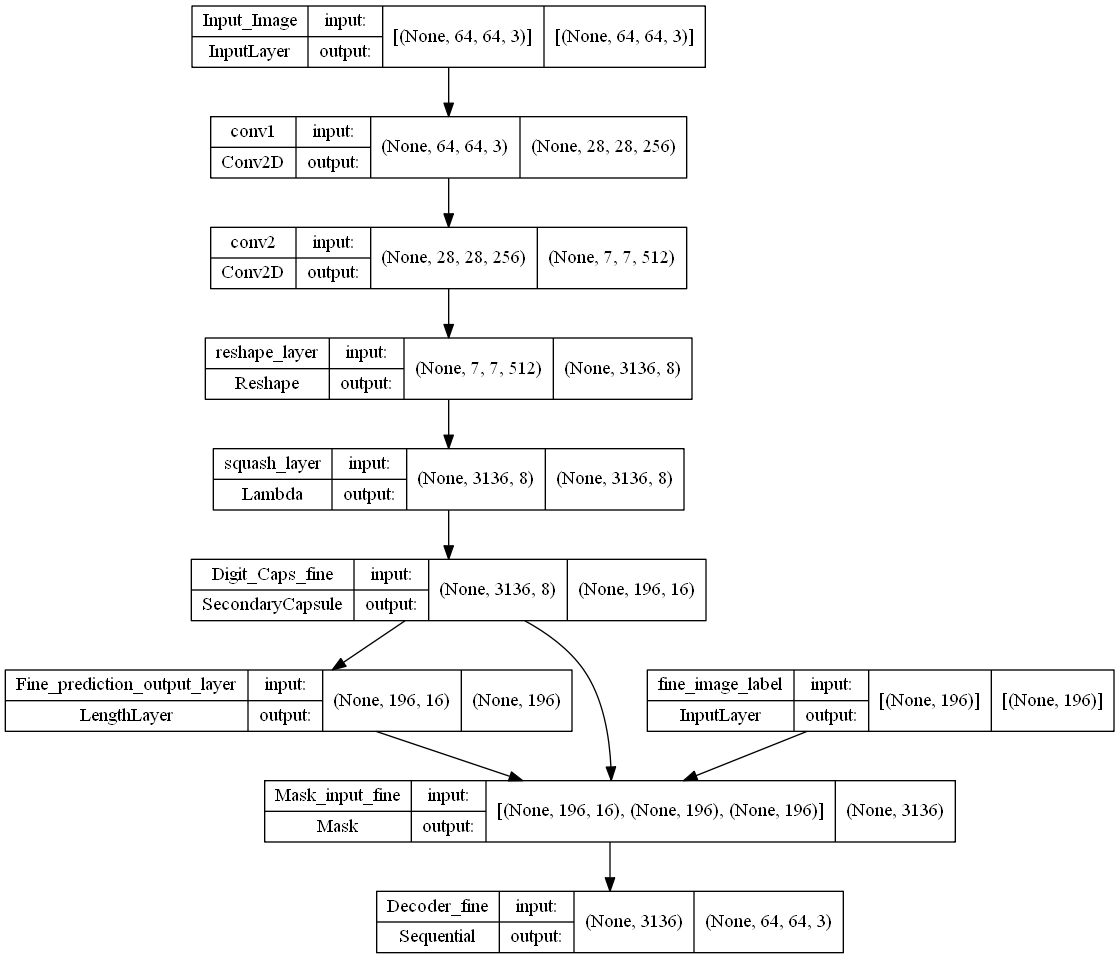

In [18]:
keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

<font color='red'><h2 align="center"> **Training Parameters** </h2></font>

## Callbacks

In [19]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))

log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-{epoch:02d}.h5',  
    monitor='val_loss',
    save_best_only=True, save_weights_only=True, verbose=1)

lr_decay = keras.callbacks.LearningRateScheduler(
    schedule=lambda epoch: train_params["lr"] * (train_params["lr_decay"] ** epoch))

# Run training

## Training Pipeline Alignment

In [20]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_2), (label_2,image)
### matchin X,Y with model input
training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset
test_dataset_match = test_dataset.map(pipeline_multi_input_output) ## test Dataset


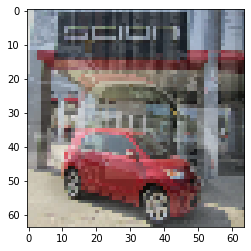

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.26300752 

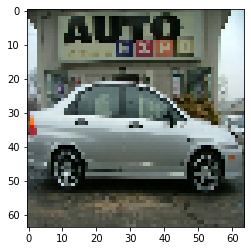

tf.Tensor(
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2621008e-06
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000

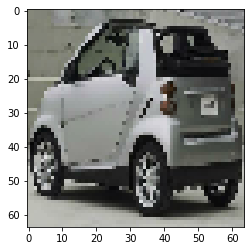

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

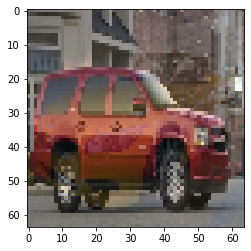

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.20921026 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.7907897  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

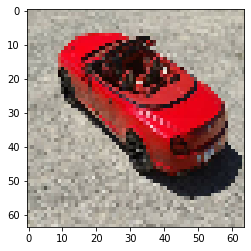

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01430231 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.9856977  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [21]:
for x,y in training_dataset_match.take(5):
    plt.imshow(x[0][0])
    plt.show()
    print(y[0][0])

## Training

In [22]:
history = model.fit(training_dataset_match,
                    batch_size = train_params["batch_size"],
                    epochs = train_params["n_epochs"],
                    validation_data = val_dataset_match,
                    callbacks =[tb, log, checkpoint, lr_decay],
                    verbose="auto")

model_save_dir = str(directory+'/trained_model.h5')

model.save_weights(model_save_dir)
print('Trained model saved to = ', model_save_dir)

Epoch 1/100
1018/1018 [==============================] - ETA: 0s - loss: 0.6880 - Fine_prediction_output_layer_loss: 0.6849 - Decoder_fine_loss: 6.9026 - Fine_prediction_output_layer_accuracy: 0.0042
Epoch 1: val_loss improved from inf to 0.67155, saving model to ./logs/CapsNet/Flat_Classification\weights-01.h5
1018/1018 [==============================] - 497s 464ms/step - loss: 0.6880 - Fine_prediction_output_layer_loss: 0.6849 - Decoder_fine_loss: 6.9026 - Fine_prediction_output_layer_accuracy: 0.0042 - val_loss: 0.6715 - val_Fine_prediction_output_layer_loss: 0.6685 - val_Decoder_fine_loss: 6.8216 - val_Fine_prediction_output_layer_accuracy: 0.0052 - lr: 0.0010
Epoch 2/100
1018/1018 [==============================] - ETA: 0s - loss: 0.6630 - Fine_prediction_output_layer_loss: 0.6599 - Decoder_fine_loss: 6.8213 - Fine_prediction_output_layer_accuracy: 0.0052
Epoch 2: val_loss improved from 0.67155 to 0.65801, saving model to ./logs/CapsNet/Flat_Classification\weights-02.h5
1018/1018 

Epoch 14/100
1018/1018 [==============================] - ETA: 0s - loss: 0.6455 - Fine_prediction_output_layer_loss: 0.6424 - Decoder_fine_loss: 6.7836 - Fine_prediction_output_layer_accuracy: 0.0054
Epoch 14: val_loss improved from 0.64579 to 0.64553, saving model to ./logs/CapsNet/Flat_Classification\weights-14.h5
1018/1018 [==============================] - 482s 465ms/step - loss: 0.6455 - Fine_prediction_output_layer_loss: 0.6424 - Decoder_fine_loss: 6.7836 - Fine_prediction_output_layer_accuracy: 0.0054 - val_loss: 0.6455 - val_Fine_prediction_output_layer_loss: 0.6424 - val_Decoder_fine_loss: 6.8506 - val_Fine_prediction_output_layer_accuracy: 0.0052 - lr: 5.1334e-04
Epoch 15/100
1018/1018 [==============================] - ETA: 0s - loss: 0.6450 - Fine_prediction_output_layer_loss: 0.6419 - Decoder_fine_loss: 6.7833 - Fine_prediction_output_layer_accuracy: 0.0052
Epoch 15: val_loss improved from 0.64553 to 0.64539, saving model to ./logs/CapsNet/Flat_Classification\weights-15.h

Epoch 27/100
1018/1018 [==============================] - ETA: 0s - loss: 0.6226 - Fine_prediction_output_layer_loss: 0.6195 - Decoder_fine_loss: 6.7615 - Fine_prediction_output_layer_accuracy: 0.0786
Epoch 27: val_loss did not improve from 0.63983
1018/1018 [==============================] - 475s 458ms/step - loss: 0.6226 - Fine_prediction_output_layer_loss: 0.6195 - Decoder_fine_loss: 6.7615 - Fine_prediction_output_layer_accuracy: 0.0786 - val_loss: 0.6431 - val_Fine_prediction_output_layer_loss: 0.6401 - val_Decoder_fine_loss: 6.7087 - val_Fine_prediction_output_layer_accuracy: 0.0221 - lr: 2.6352e-04
Epoch 28/100
1018/1018 [==============================] - ETA: 0s - loss: 0.6181 - Fine_prediction_output_layer_loss: 0.6150 - Decoder_fine_loss: 6.7521 - Fine_prediction_output_layer_accuracy: 0.1094
Epoch 28: val_loss did not improve from 0.63983
1018/1018 [==============================] - 475s 458ms/step - loss: 0.6181 - Fine_prediction_output_layer_loss: 0.6150 - Decoder_fine_los

1018/1018 [==============================] - 475s 458ms/step - loss: 0.5195 - Fine_prediction_output_layer_loss: 0.5164 - Decoder_fine_loss: 6.6294 - Fine_prediction_output_layer_accuracy: 0.6265 - val_loss: 0.6590 - val_Fine_prediction_output_layer_loss: 0.6560 - val_Decoder_fine_loss: 6.6070 - val_Fine_prediction_output_layer_accuracy: 0.0400 - lr: 1.3528e-04
Epoch 41/100
1018/1018 [==============================] - ETA: 0s - loss: 0.5110 - Fine_prediction_output_layer_loss: 0.5080 - Decoder_fine_loss: 6.6251 - Fine_prediction_output_layer_accuracy: 0.6573
Epoch 41: val_loss did not improve from 0.63983
1018/1018 [==============================] - 475s 459ms/step - loss: 0.5110 - Fine_prediction_output_layer_loss: 0.5080 - Decoder_fine_loss: 6.6251 - Fine_prediction_output_layer_accuracy: 0.6573 - val_loss: 0.6607 - val_Fine_prediction_output_layer_loss: 0.6577 - val_Decoder_fine_loss: 6.6025 - val_Fine_prediction_output_layer_accuracy: 0.0378 - lr: 1.2851e-04
Epoch 42/100
1018/1018 

Epoch 54/100
1018/1018 [==============================] - ETA: 0s - loss: 0.4254 - Fine_prediction_output_layer_loss: 0.4223 - Decoder_fine_loss: 6.5571 - Fine_prediction_output_layer_accuracy: 0.8701
Epoch 54: val_loss did not improve from 0.63983
1018/1018 [==============================] - 475s 459ms/step - loss: 0.4254 - Fine_prediction_output_layer_loss: 0.4223 - Decoder_fine_loss: 6.5571 - Fine_prediction_output_layer_accuracy: 0.8701 - val_loss: 0.6717 - val_Fine_prediction_output_layer_loss: 0.6688 - val_Decoder_fine_loss: 6.5699 - val_Fine_prediction_output_layer_accuracy: 0.0455 - lr: 6.5971e-05
Epoch 55/100
1018/1018 [==============================] - ETA: 0s - loss: 0.4218 - Fine_prediction_output_layer_loss: 0.4187 - Decoder_fine_loss: 6.5510 - Fine_prediction_output_layer_accuracy: 0.8739
Epoch 55: val_loss did not improve from 0.63983
1018/1018 [==============================] - 475s 459ms/step - loss: 0.4218 - Fine_prediction_output_layer_loss: 0.4187 - Decoder_fine_los

1018/1018 [==============================] - 475s 459ms/step - loss: 0.3829 - Fine_prediction_output_layer_loss: 0.3798 - Decoder_fine_loss: 6.5360 - Fine_prediction_output_layer_accuracy: 0.9161 - val_loss: 0.6775 - val_Fine_prediction_output_layer_loss: 0.6745 - val_Decoder_fine_loss: 6.5680 - val_Fine_prediction_output_layer_accuracy: 0.0475 - lr: 3.3866e-05
Epoch 68/100
1018/1018 [==============================] - ETA: 0s - loss: 0.3792 - Fine_prediction_output_layer_loss: 0.3761 - Decoder_fine_loss: 6.5383 - Fine_prediction_output_layer_accuracy: 0.9191
Epoch 68: val_loss did not improve from 0.63983
1018/1018 [==============================] - 475s 459ms/step - loss: 0.3792 - Fine_prediction_output_layer_loss: 0.3761 - Decoder_fine_loss: 6.5383 - Fine_prediction_output_layer_accuracy: 0.9191 - val_loss: 0.6771 - val_Fine_prediction_output_layer_loss: 0.6742 - val_Decoder_fine_loss: 6.5617 - val_Fine_prediction_output_layer_accuracy: 0.0473 - lr: 3.2172e-05
Epoch 69/100
1018/1018 

Epoch 81/100
1018/1018 [==============================] - ETA: 0s - loss: 0.3598 - Fine_prediction_output_layer_loss: 0.3567 - Decoder_fine_loss: 6.5236 - Fine_prediction_output_layer_accuracy: 0.9361
Epoch 81: val_loss did not improve from 0.63983
1018/1018 [==============================] - 473s 458ms/step - loss: 0.3598 - Fine_prediction_output_layer_loss: 0.3567 - Decoder_fine_loss: 6.5236 - Fine_prediction_output_layer_accuracy: 0.9361 - val_loss: 0.6806 - val_Fine_prediction_output_layer_loss: 0.6776 - val_Decoder_fine_loss: 6.5663 - val_Fine_prediction_output_layer_accuracy: 0.0458 - lr: 1.6515e-05
Epoch 82/100
1018/1018 [==============================] - ETA: 0s - loss: 0.3600 - Fine_prediction_output_layer_loss: 0.3569 - Decoder_fine_loss: 6.5279 - Fine_prediction_output_layer_accuracy: 0.9323
Epoch 82: val_loss did not improve from 0.63983
1018/1018 [==============================] - 473s 457ms/step - loss: 0.3600 - Fine_prediction_output_layer_loss: 0.3569 - Decoder_fine_los

1018/1018 [==============================] - 474s 458ms/step - loss: 0.3506 - Fine_prediction_output_layer_loss: 0.3475 - Decoder_fine_loss: 6.5084 - Fine_prediction_output_layer_accuracy: 0.9392 - val_loss: 0.6819 - val_Fine_prediction_output_layer_loss: 0.6789 - val_Decoder_fine_loss: 6.5631 - val_Fine_prediction_output_layer_accuracy: 0.0460 - lr: 8.4780e-06
Epoch 95/100
1018/1018 [==============================] - ETA: 0s - loss: 0.3499 - Fine_prediction_output_layer_loss: 0.3468 - Decoder_fine_loss: 6.5145 - Fine_prediction_output_layer_accuracy: 0.9428
Epoch 95: val_loss did not improve from 0.63983
1018/1018 [==============================] - 474s 458ms/step - loss: 0.3499 - Fine_prediction_output_layer_loss: 0.3468 - Decoder_fine_loss: 6.5145 - Fine_prediction_output_layer_accuracy: 0.9428 - val_loss: 0.6818 - val_Fine_prediction_output_layer_loss: 0.6789 - val_Decoder_fine_loss: 6.5617 - val_Fine_prediction_output_layer_accuracy: 0.0448 - lr: 8.0541e-06
Epoch 96/100
1018/1018 

In [23]:
history_dict = history.history
# history_dict.keys()
n=1
print('\033[91m','\033[1m',"\n==>","Parameters in history = ", '\033[0m')
for key, value in history_dict.items():
    print(n, "-->", key)
    n+=1
    
# print('\033[91m','\033[1m',"\n==>","Parameters and values in history = ", '\033[0m')
# n=1
# print('\n\nVALUE of the key parameters')
# for key, value in history_dict.items():
#     print(n, "-->", key, ' : ', value)
#     n+=1

  
==> Parameters in history =  
1 --> loss
2 --> Fine_prediction_output_layer_loss
3 --> Decoder_fine_loss
4 --> Fine_prediction_output_layer_accuracy
5 --> val_loss
6 --> val_Fine_prediction_output_layer_loss
7 --> val_Decoder_fine_loss
8 --> val_Fine_prediction_output_layer_accuracy
9 --> lr


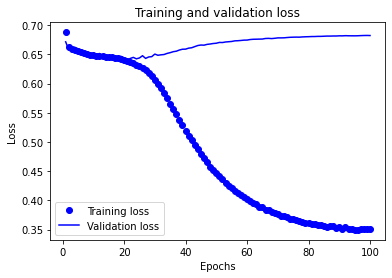

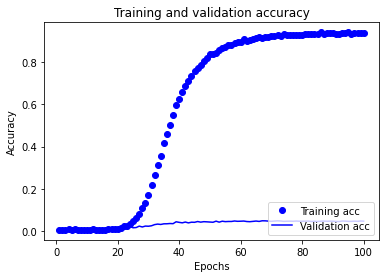

In [24]:
acc = history_dict['Fine_prediction_output_layer_accuracy']
val_acc = history_dict['val_Fine_prediction_output_layer_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Model evaluate

In [25]:
print(model.metrics_names)

['loss', 'Fine_prediction_output_layer_loss', 'Decoder_fine_loss', 'Fine_prediction_output_layer_accuracy']


In [26]:
results = model.evaluate(test_dataset_match,
                         verbose=1)

503/503 [==============================] - 64s 127ms/step - loss: 0.6823 - Fine_prediction_output_layer_loss: 0.6794 - Decoder_fine_loss: 6.5639 - Fine_prediction_output_layer_accuracy: 0.0458


In [27]:
for n in range(len(results)):
    print(n+1,'_',model.metrics_names[n], '==>', results[n],'\n')

1 _ loss ==> 0.6823246479034424 

2 _ Fine_prediction_output_layer_loss ==> 0.6793820261955261 

3 _ Decoder_fine_loss ==> 6.563859939575195 

4 _ Fine_prediction_output_layer_accuracy ==> 0.04575975984334946 



# Model Prediction

In [28]:
predictions = model.predict(test_dataset_match,
                            verbose=1
                           )

503/503 [==============================] - 63s 123ms/step


In [29]:
print('\033[91m','\033[1m',"\nModel prediction array shape:", '\033[0m')
for n in range(len(predictions)):
    print("predictions[{0}]:".format(n), predictions[n].shape)

  
Model prediction array shape: 
predictions[0]: (4021, 196)
predictions[1]: (4021, 64, 64, 3)


# Analysis

In [30]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
    return y_true, y_pred

In [31]:
pred = []
pred.append(predict_from_pipeline(model, test_dataset_match))

In [32]:
y_true = pred[0][0]
y_pred = pred[0][1]

y_true_fine, image = y_true[0], y_true[1]
y_pred_fine, image_recon = y_pred[0], y_pred[1]

In [33]:
true_label = [y_true_fine,y_true_fine]
pred_label = [y_pred_fine,y_pred_fine]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[5 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]

  • FINE LEVEL 
[[5 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]

  • Classification Report 


  • COARSE LEVEL 


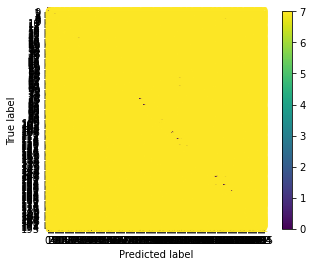

              precision    recall  f1-score   support

           0    0.10638   0.26316   0.15152        19
           1    0.00000   0.00000   0.00000        20
           2    0.00000   0.00000   0.00000        21
           3    0.00000   0.00000   0.00000        24
           4    0.00000   0.00000   0.00000        21
           5    0.25000   0.22222   0.23529        18
           6    0.00000   0.00000   0.00000        19
           7    0.00000   0.00000   0.00000        22
           8    0.00000   0.00000   0.00000        18
           9    0.00000   0.00000   0.00000        20
          10    0.09524   0.08696   0.09091        23
          11    0.00000   0.00000   0.00000        21
          12    0.00000   0.00000   0.00000        22
          13    0.00000   0.00000   0.00000        19
          14    0.14286   0.04762   0.07143        21
          15    0.00000   0.00000   0.00000        22
          16    0.10000   0.10000   0.10000        20
          17    0.00000   0

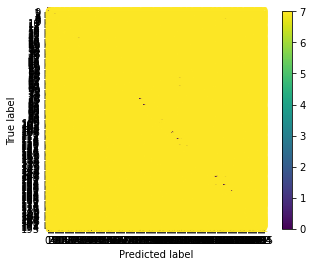

              precision    recall  f1-score   support

           0    0.10638   0.26316   0.15152        19
           1    0.00000   0.00000   0.00000        20
           2    0.00000   0.00000   0.00000        21
           3    0.00000   0.00000   0.00000        24
           4    0.00000   0.00000   0.00000        21
           5    0.25000   0.22222   0.23529        18
           6    0.00000   0.00000   0.00000        19
           7    0.00000   0.00000   0.00000        22
           8    0.00000   0.00000   0.00000        18
           9    0.00000   0.00000   0.00000        20
          10    0.09524   0.08696   0.09091        23
          11    0.00000   0.00000   0.00000        21
          12    0.00000   0.00000   0.00000        22
          13    0.00000   0.00000   0.00000        19
          14    0.14286   0.04762   0.07143        21
          15    0.00000   0.00000   0.00000        22
          16    0.10000   0.10000   0.10000        20
          17    0.00000   0

In [34]:
metrics.lvl_wise_metric(true_label,pred_label)